In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [3]:
TOTAL_IMAGE_PER_CAMERA = 40
THESHOLD_RATIO = 0.10

In [2]:
#INPUT_PATH = 'datasets/totoro_blackplate_singlecam/%03d%03d.png'
INPUT_PATH = 'datasets/green_in_glass_singlecam/%03d%03d.png'

In [4]:
def get_diff_mask(camerea_id,current_shot):
    previous_shot = (current_shot - 1) % TOTAL_IMAGE_PER_CAMERA
    # read image
    image_prev_uint = cv2.imread(INPUT_PATH % (camerea_id,previous_shot)) 
    image_current_uint = cv2.imread(INPUT_PATH % (camerea_id,current_shot)) 
    # convert to RGB
    image_prev_uint = cv2.cvtColor(image_prev_uint,cv2.COLOR_BGR2RGB)
    image_current_uint = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2RGB)
    # rotate
    image_prev_uint = cv2.rotate(image_prev_uint, cv2.ROTATE_90_CLOCKWISE)
    image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
    # convert to [0-1]
    image_prev =  image_prev_uint / 255.0
    image_current = image_current_uint / 255.0
    # difference mask between 2 images
    diff_mask = np.linalg.norm(image_current - image_prev, axis=-1)
    diff_mask = (diff_mask > THESHOLD_RATIO) * 1.0
    #remove noise from sensor (hope this not ruin image)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    denoised_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel)
    return denoised_mask

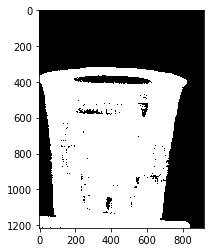

In [5]:
CAMERA_NUMBER = 0
foreground_prob = get_diff_mask(CAMERA_NUMBER,0)
for i in range(1,40):
    foreground_prob = cv2.bitwise_or(foreground_prob,get_diff_mask(CAMERA_NUMBER,i))
plt.imshow(foreground_prob,cmap='gray')

In [6]:
image_flooded = (foreground_prob.copy() * 255.0).astype(np.uint8)
image_height, image_width = image_flooded.shape[:2]
flood_mask = np.zeros((image_height+2,image_width+2),dtype=np.uint8)
# top bar
for i in range(image_flooded.shape[1]):
    if image_flooded[0,i] != 255:
        cv2.floodFill(image_flooded, flood_mask, (0,i), 255)
# left bar
for i in range(image_flooded.shape[0]):
    if image_flooded[i,0] != 255:
        cv2.floodFill(image_flooded, flood_mask, (i,0), 255)

# right bar
most_right = image_flooded.shape[1] -1
for i in range(image_flooded.shape[0]):
    if image_flooded[i,most_right] != 255:
        cv2.floodFill(image_flooded, flood_mask, (i,most_right), 255)

# bottom bar 
most_bottom = image_flooded.shape[0] -1
for i in range(image_flooded.shape[1]):
    if image_flooded[most_bottom,i] != 255:
        cv2.floodFill(image_flooded, flood_mask, (most_bottom,i), 255)


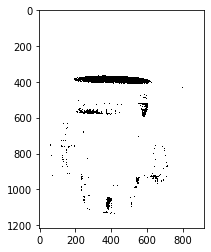

In [7]:
plt.imshow(image_flooded,cmap='gray')

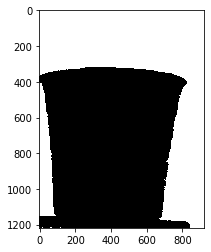

In [8]:
plt.imshow(flood_mask,cmap='gray')

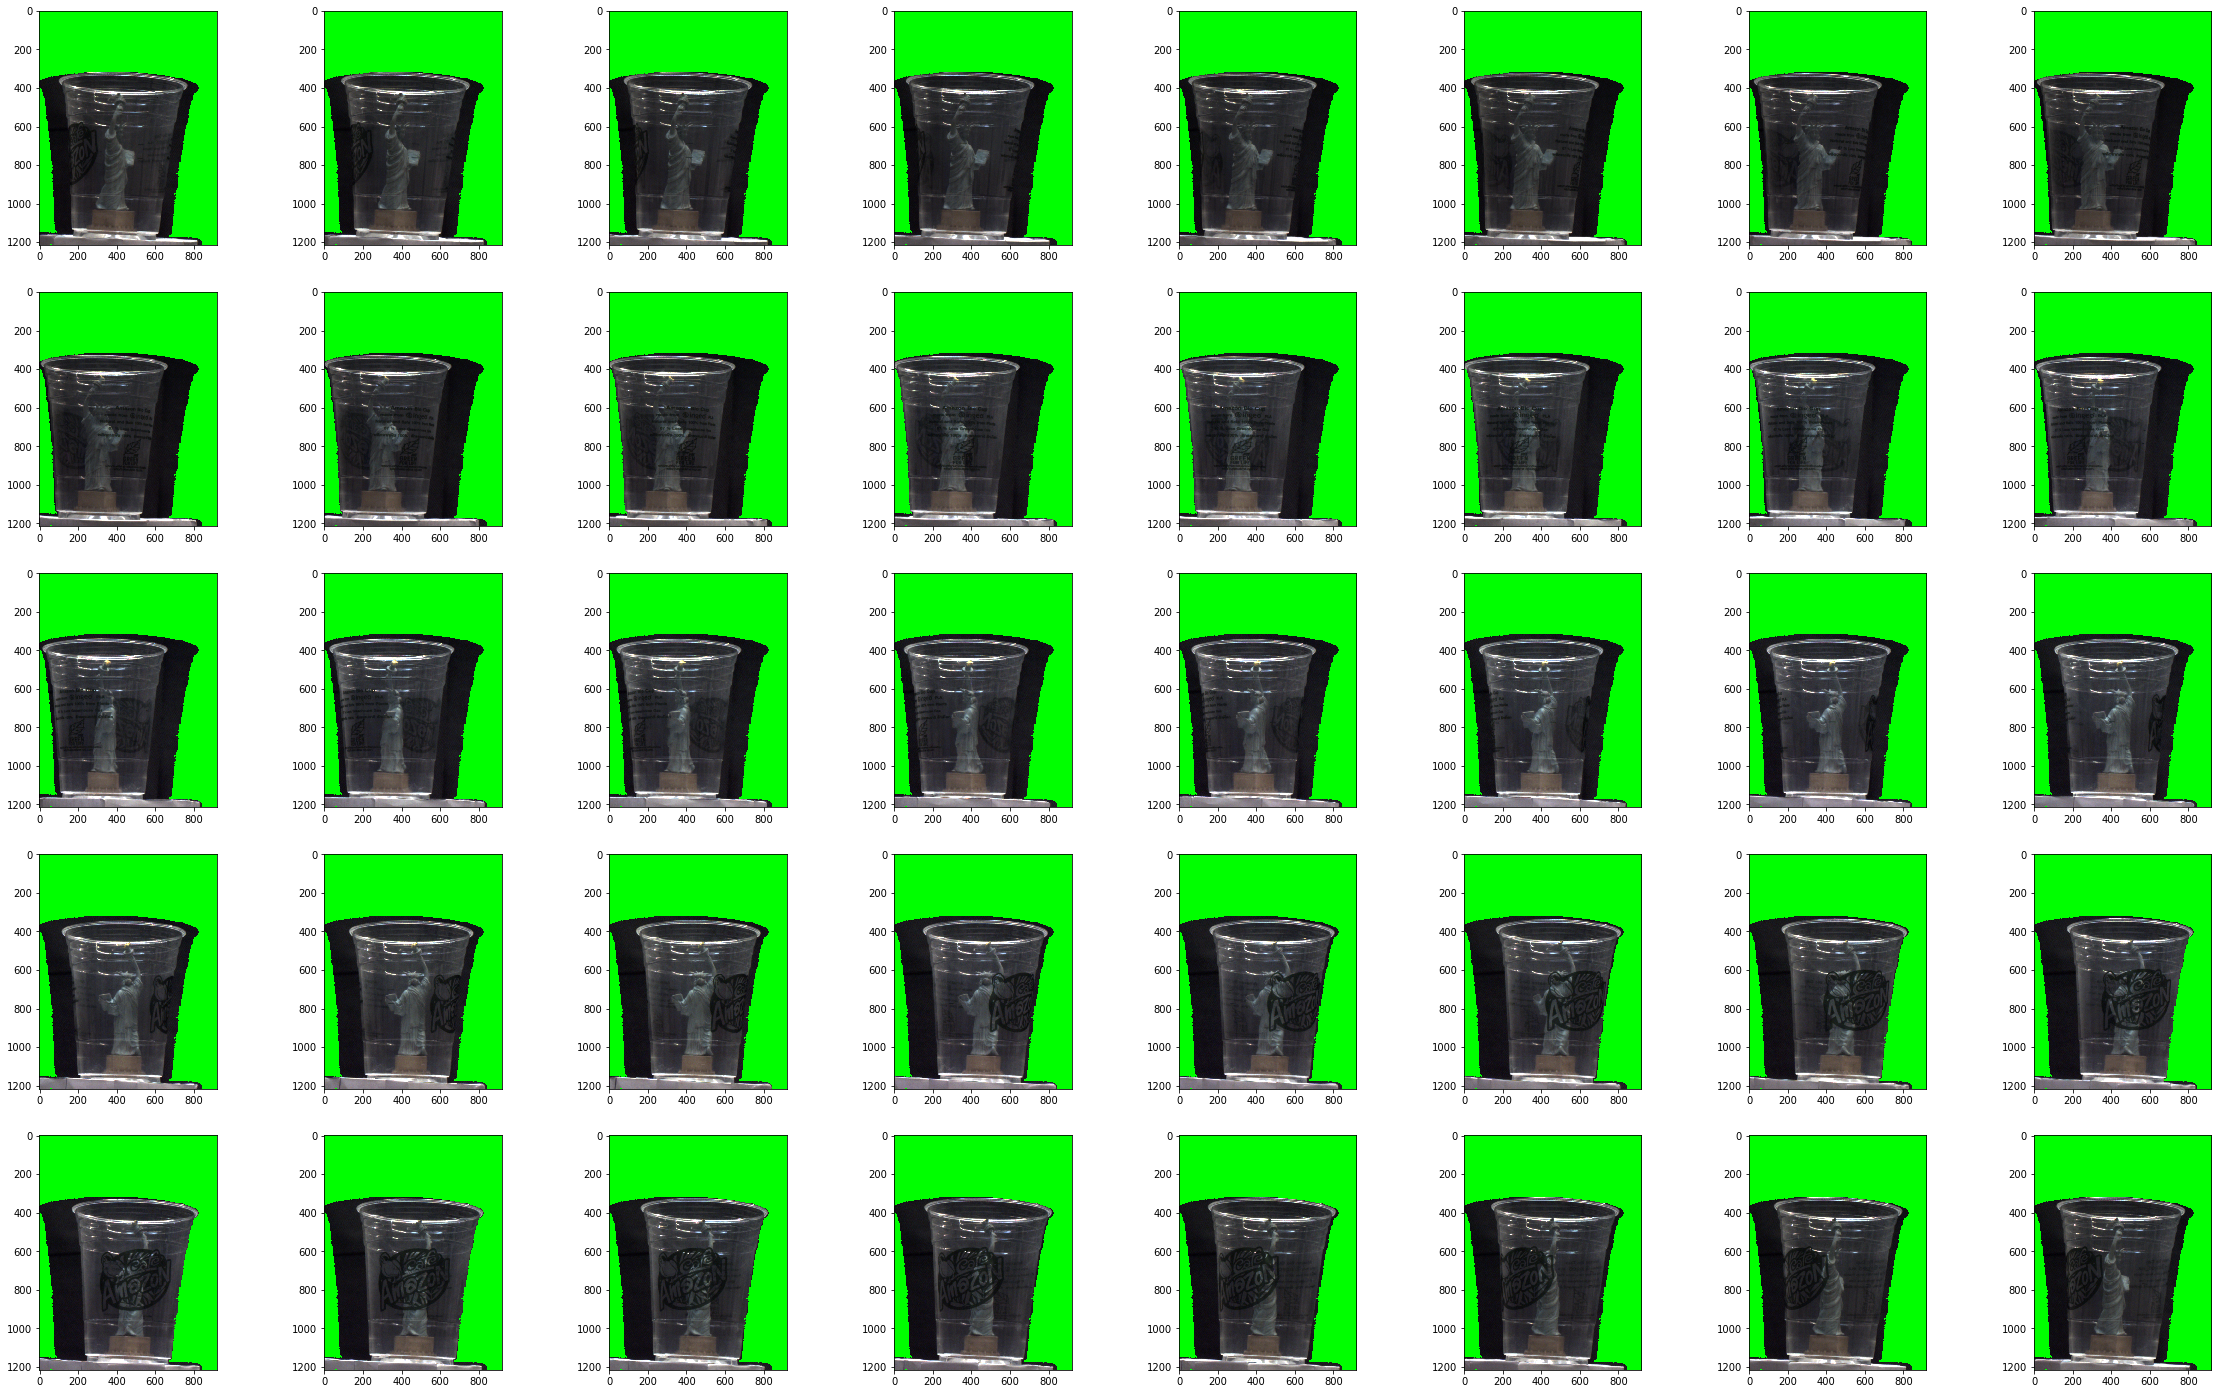

In [9]:
background_mask = flood_mask[1:-1,1:-1]
fig, axs = plt.subplots(5, 8,figsize=(40,25))
figsize=(18, 16)
for row in range(5):
    for col in range(8):
        image = plt.imread(INPUT_PATH % (0,row*8+col))
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        image[background_mask == 1] = [0,1,0]
        axs[row,col].imshow(image)
plt.show()

In [16]:
image = cv2.imread(INPUT_PATH % (0,20))
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
gc_mask = np.zeros(image.shape[:2],dtype=np.uint8)
gc_mask[background_mask == 1] = cv2.GC_BGD
gc_mask[background_mask != 1] = cv2.GC_PR_FGD
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)
output = cv2.grabCut(image.copy(), gc_mask, (0,0,0,0), bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)

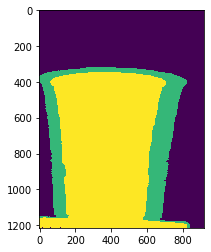

In [18]:
plt.imshow(output[0])

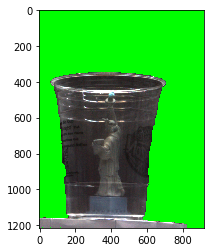

In [22]:
output_image = image.copy()
output_image[output[0] != cv2.GC_PR_FGD] = (0,255,0)
plt.imshow(output_image) 